# Introduction to PyTorch

Welcome to this week's programming assignment! Up until now, you've always used Numpy to build neural networks, but this week you'll explore a deep learning framework that allows you to build neural networks more easily. Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up your machine learning development significantly. PyTorch has made significant improvements over its predecessor, some of which you'll encounter and implement here!

Programming frameworks like PyTorch not only cut down on time spent coding, but can also perform optimizations that speed up the code itself. 

## Table of Contents
- [1- Packages](#1)
    - [1.1 - Checking TensorFlow Version](#1-1)
- [2 - Basic Optimization with GradientTape](#2)
    - [2.1 - Linear Function](#2-1)
        - [Exercise 1 - linear_function](#ex-1)
    - [2.2 - Computing the Sigmoid](#2-2)
        - [Exercise 2 - sigmoid](#ex-2)
    - [2.3 - Using One Hot Encodings](#2-3)
        - [Exercise 3 - one_hot_matrix](#ex-3)
    - [2.4 - Initialize the Parameters](#2-4)
        - [Exercise 4 - initialize_parameters](#ex-4)
- [3 - Building Your First Neural Network in TensorFlow](#3)
    - [3.1 - Implement Forward Propagation](#3-1)
        - [Exercise 5 - forward_propagation](#ex-5)
    - [3.2 Compute the Cost](#3-2)
        - [Exercise 6 - compute_cost](#ex-6)
    - [3.3 - Train the Model](#3-3)
- [4 - Bibliography](#4)

<a name='1'></a>
## 1 - Packages

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim

<a name='1-1'></a>
### 1.1 - Checking PyTorch Version 

In [2]:
torch.__version__

'1.12.1+cu113'

In [ ]:
train_dataset = h5py.File('./datasets/train_signs.h5', "r")
test_dataset = h5py.File('./datasets/test_signs.h5', "r")

In [6]:
x_train = np.array(train_dataset['train_set_x'])
y_train = np.array(train_dataset['train_set_y'])

x_test = np.array(test_dataset['test_set_x'])
y_test = np.array(test_dataset['test_set_y'])

In [7]:
print(x_train.shape)
print(y_train.shape)

(1080, 64, 64, 3)
(1080,)


## PyTorch Dataset & DataLoader
데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 어려울 수 있습니다; 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다. PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다. Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.

## PyTorch Dataset

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: \_\_init\_\_, \_\_len\_\_, and \_\_getitem\_\_. 

`__init__`  
\_\_init\_\_ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다. 

`__len__`  
\_\_len\_\_ 함수는 데이터셋의 샘플 개수를 반환합니다.

`__getitem__`  
\_\_getitem\_\_ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다.


In [8]:
from torch.utils.data import Dataset, DataLoader

In [11]:
class Custom_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        # normalize(/255.0)
        # flatten(use reshape(-1))
        normalized_x = self.x[idx] / 255
        # YOUR CODE STARTS HERE
        reshaped_normalized_x = normalized_x.reshape(-1)
        # YOUR CODE ENDS HERE
        return {
            'x' : reshaped_normalized_x,
            'y' : self.y[idx]
        }

In [12]:
train_custom_dataset = Custom_Dataset(x_train, y_train)
test_custom_dataset = Custom_Dataset(x_test, y_test)

In [13]:
type(train_custom_dataset)

__main__.Custom_Dataset

In [14]:
print('__len__ :', len(train_custom_dataset))
print('__len__ :', train_custom_dataset.__len__())

__len__ : 1080
__len__ : 1080


In [15]:
print('__getitem__ :', train_custom_dataset[0])
print('__getitem__ :', train_custom_dataset.__getitem__(0))

__getitem__ : {'x': array([0.89019608, 0.8627451 , 0.83921569, ..., 0.81568627, 0.81960784,
       0.81960784]), 'y': 5}
__getitem__ : {'x': array([0.89019608, 0.8627451 , 0.83921569, ..., 0.81568627, 0.81960784,
       0.81960784]), 'y': 5}


## PyTorch DataLoader
`Dataset` 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 “미니배치(minibatch)”로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려고 합니다. `DataLoader` 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)입니다.

`DataLoader` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있습니다. 아래의 각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환합니다. shuffle=True 로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞입니다.

In [16]:
train_loader = DataLoader(train_custom_dataset,
                          batch_size = 64,
                          shuffle = True)
test_loader = DataLoader(test_custom_dataset,
                         batch_size = 64,
                         shuffle = True)

since PyTorch DataLoader are generators, you can't access directly the contents unless you iterate over them in a for loop, or by explicitly creating a Python iterator using iter and consuming its elements using next.

In [17]:
print('data dictionary :', next(iter(train_loader)))

data dictionary : {'x': tensor([[0.9020, 0.8627, 0.8196,  ..., 0.7922, 0.7804, 0.7725],
        [0.8863, 0.8431, 0.7804,  ..., 0.7333, 0.6980, 0.6706],
        [0.9098, 0.8784, 0.8353,  ..., 0.4824, 0.3294, 0.2392],
        ...,
        [0.9176, 0.8941, 0.8667,  ..., 0.8118, 0.7765, 0.7373],
        [0.8667, 0.8314, 0.7686,  ..., 0.7843, 0.7529, 0.7412],
        [0.9216, 0.8863, 0.8549,  ..., 0.6902, 0.6275, 0.5725]],
       dtype=torch.float64), 'y': tensor([5, 1, 3, 1, 5, 5, 4, 1, 5, 2, 4, 5, 1, 0, 5, 5, 1, 0, 2, 5, 2, 3, 3, 3,
        5, 0, 5, 3, 4, 4, 1, 2, 4, 2, 4, 0, 1, 0, 1, 2, 0, 5, 0, 2, 4, 3, 2, 4,
        0, 2, 5, 2, 1, 1, 5, 3, 3, 1, 1, 0, 5, 0, 2, 0])}


In [18]:
print('x :', next(iter(train_loader))['x'])
print('shape of x :', next(iter(train_loader))['x'].size()) # (batch size, w, h, c)

x : tensor([[0.9176, 0.8863, 0.8510,  ..., 0.7882, 0.7294, 0.6745],
        [0.9059, 0.8745, 0.8471,  ..., 0.7961, 0.7725, 0.7412],
        [0.9137, 0.8784, 0.8471,  ..., 0.7373, 0.6706, 0.6157],
        ...,
        [0.9020, 0.8667, 0.8353,  ..., 0.7529, 0.7294, 0.6980],
        [0.9137, 0.8902, 0.8588,  ..., 0.7843, 0.7725, 0.7373],
        [0.8980, 0.8627, 0.8235,  ..., 0.4235, 0.2667, 0.1647]],
       dtype=torch.float64)
shape of x : torch.Size([64, 12288])


In [19]:
print('y :', next(iter(train_loader))['y'])
print('shape of y :', next(iter(train_loader))['y'].size()) # (batch size,)

y : tensor([3, 1, 0, 2, 1, 3, 3, 0, 5, 5, 5, 3, 5, 5, 2, 1, 5, 2, 1, 3, 1, 3, 3, 4,
        5, 0, 2, 0, 4, 1, 5, 1, 0, 1, 3, 0, 3, 1, 1, 5, 2, 3, 0, 4, 5, 4, 4, 5,
        2, 0, 1, 5, 4, 3, 3, 0, 5, 5, 4, 4, 5, 1, 5, 3])
shape of y : torch.Size([64])


The dataset that you'll be using during this assignment is a subset of the sign language digits. It contains six different classes representing the digits from 0 to 5.

In [ ]:
unique_labels = set()
for mini_batch in train_loader:
    y = mini_batch['y']
    for element in y.numpy():
        unique_labels.add(element)
        
print(unique_labels)

You can see some of the images in the dataset by running the following cell.

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow((train_custom_dataset[i]['x']  * 255).astype("uint8").reshape(64, 64, 3))
    plt.title(train_custom_dataset[i]['y'].astype("uint8"))
    plt.axis("off")

<a name='2-1'></a>
### 2.1 - Linear Function

Let's begin this programming exercise by computing the following equation: $Y = WX + b$, where $W$ and $X$ are random matrices and b is a random vector. 

<a name='ex-1'></a>
### Exercise 1 - linear_function

Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. W is of shape (4, 3), X is (3,1) and b is (4,1). As an example, this is how to define a constant X with the shape (3,1):
```python
X = torch.Tensor(np.random.randn(3,1))

```

You might find the following functions helpful: 
- `torch.matmul(..., ...)` to do a matrix multiplication
- `torch.add(..., ...)` to do an addition
- `np.random.randn(...)` to initialize randomly

In [22]:
def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """

    np.random.seed(1)
    
    """
    Note, to ensure that the "random" numbers generated match the expected results,
    please create the variables in the order given in the starting code below.
    (Do not re-arrange the order).
    """
    # YOUR CODE STARTS HERE
    # (approx. 4 lines)
    X = torch.Tensor(np.random.randn(3,1))
    W = torch.Tensor(np.random.randn(4,3))
    b = torch.Tensor(np.random.randn(4,1))
    Y = torch.matmul(W, X)+b
    # YOUR CODE ENDS HERE
    
    return Y

In [23]:
result = linear_function()
print(result)

tensor([[-2.1566],
        [ 2.9589],
        [-1.0893],
        [-0.8454]])


**Expected Output**: 

```
tensor([[-2.1566],
        [ 2.9589],
        [-1.0893],
        [-0.8454]])
```

<a name='2-2'></a>
### 2.2 - Computing the Sigmoid 
Amazing! You just implemented a linear function. PyTorch offers a variety of commonly used neural network functions like `torch.nn.functional.sigmoid` and `torch.nn.functional.softmax`.

For this exercise, compute the sigmoid of z. 

In this exercise, you will: Cast your tensor to type `float32` using `tensor.type`, then compute the sigmoid using `torch.nn.functional.sigmoid`. 

<a name='ex-2'></a>
### Exercise 2 - sigmoid

Implement the sigmoid function below. You should use the following: 

- `z.type(torch.float32)`
- `torch.nn.functional.sigmoid('...')`

In [26]:
def sigmoid(z):
    
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (torch.float32) the sigmoid of z
    """
    z = torch.tensor(z)
    # tf.keras.activations.sigmoid requires float16, float32, float64, complex64, or complex128.
    # YOUR CODE STARTS HERE
    # (approx. 2 lines)
    # z = 
    a = torch.nn.functional.sigmoid(z)
    # YOUR CODE ENDS HERE
    return a

In [27]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

type: <class 'torch.Tensor'>
dtype: torch.float32
sigmoid(-1) = tensor(0.2689)
sigmoid(0) = tensor(0.5000)
sigmoid(12) = tensor(1.0000)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


**Expected Output**: 
<table>
<tr> 
<td>
type
</td>
<td>
class 'torch.Tensor'
</td>
</tr><tr> 
<td>
dtype
</td>
<td>
'torch.float32'
</td>
</tr>
<tr> 
<td>
Sigmoid(-1)
</td>
<td>
0.2689
</td>
</tr>
<tr> 
<td>
Sigmoid(0)
</td>
<td>
0.5000
</td>
</tr>
<tr> 
<td>
Sigmoid(12)
</td>
<td>
1.0000
</td>
</tr> 

</table> 

<a name='2-3'></a>
### 2.3 - Using One Hot Encodings

Many times in deep learning you will have a $Y$ vector with numbers ranging from $0$ to $C-1$, where $C$ is the number of classes. If $C$ is for example 4, then you might have the following y vector which you will need to convert like this:


<img src="images/onehot.png" style="width:600px;height:150px;">

This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In PyTorch, you can use one line of code: 

- [torch.nn.functional.one_hot(tensor, num_classes= - 1)](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html)

`num_classes = -1` indicates the number of classes will be inferred as one greater than the largest class value in the input tensor.

<a name='ex-3'></a>
### Exercise 3 - one_hot_matrix

Implement the function below to take one label and the total number of classes $C$, and return the one hot encoding in a column wise matrix. Use `torch.nn.functional.one_hot()` to do this.

In [28]:
def one_hot_matrix(label, num_classes = 6):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (LongTensor) Categorical labels
        num_classes --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- torch.Tensor
    """
    # YOUR CODE STARTS HERE
    # (approx. 1 line)
    one_hot = torch.nn.functional.one_hot(label, num_classes)
    # YOUR CODE ENDS HERE
    return one_hot

In [29]:
test_1 = {
    'label' : torch.LongTensor([1]),
    'num_classes' : 4
}
test_2 = {
    'label' : torch.LongTensor([2]),
    'num_classes' : 4
}

print('Test 1:', one_hot_matrix(test_1['label'], test_1['num_classes']))
print('Test 2:', one_hot_matrix(test_2['label'], test_2['num_classes']))

Test 1: tensor([[0, 1, 0, 0]])
Test 2: tensor([[0, 0, 1, 0]])


**Expected output**
```
Test 1: tensor([[0, 1, 0, 0]])
Test 2: tensor([[0, 0, 1, 0]])
```

<a name='2-4'></a>
### 2.4 - Initialize the Parameters 

Now you'll initialize a vector of numbers with the Glorot(xavier normal) initializer. The function you'll be calling is `torch.nn.init.xavier_normal_`, which draws samples from a truncated normal distribution centered on 0, with `stddev = sqrt(2 / (fan_in + fan_out))`, where `fan_in` is the number of input units and `fan_out` is the number of output units, both in the weight tensor. 


<a name='ex-4'></a>
### Exercise 4 - initialize_parameters

Implement the function below to take in a shape and to return an array of numbers using the GlorotNormal(xavier normal) initializer. 

 - `W = torch.empty(shape)`
 - `torch.nn.init.xavier_normal_(W, dtype = torch.float32)`

In [30]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with PyTorch. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """                  
    
    torch.manual_seed(1)
    
    # YOUR CODE STARTS HERE
    #(approx. 6 lines of code)
    W1 = torch.nn.init.xavier_normal_(torch.empty(25, 12288, dtype = torch.float32))
    b1 = torch.nn.init.xavier_normal_(torch.empty(25, 1, dtype = torch.float32))
    W2 = torch.nn.init.xavier_normal_(torch.empty(12, 25, dtype = torch.float32))
    b2 = torch.nn.init.xavier_normal_(torch.empty(12, 1, dtype = torch.float32))
    W3 = torch.nn.init.xavier_normal_(torch.empty(6, 12, dtype = torch.float32))
    b3 = torch.nn.init.xavier_normal_(torch.empty(6, 1, dtype = torch.float32))
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [31]:
parameters = initialize_parameters()

for key in parameters:
    print(f'{key} shape: {tuple(parameters[key].shape)}')

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)


**Expected output**
```
W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
```

<a name='3'></a>
## 3 - Building Your First Neural Network in PyTorch

In this part of the assignment you will build a neural network using PyTorch. Remember that there are two parts to implementing a PyTorch model:

- Implement forward propagation
- Retrieve the gradients and train the model

Let's get into it!

<a name='3-1'></a>
### 3.1 - Implement Forward Propagation 

One of PyTorch's great strengths lies in the fact that you only need to implement the forward propagation function and it will keep track of the operations you did to calculate the back propagation automatically.  


<a name='ex-5'></a>
### Exercise 5 - forward_propagation

Implement the `forward_propagation` function.

**Note** Use only the torch. 

- torch.add
- torch.matmul
- torch.nn.functional.relu


In [32]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #(approx. 5 lines)                   # Numpy Equivalents:
    # YOUR CODE STARTS HERE
    Z1 = torch.add(torch.matmul(W1, X), b1)           # Z1 = np.dot(W1, X) + b1
    A1 = torch.nn.functional.relu(Z1)                 # A1 = relu(Z1)
    Z2 = torch.add(torch.matmul(W2, A1), b2)          # Z2 = np.dot(W2, A1) + b2
    A2 = torch.nn.functional.relu(Z2)                 # A2 = relu(Z2)
    Z3 = torch.add(torch.matmul(W3, A2), b3)          # Z3 = np.dot(W3, A2) + b3
    # YOUR CODE ENDS HERE
    
    return Z3

In [33]:
test_sample1 = torch.FloatTensor(train_custom_dataset[0]['x'])
test_sample2 = torch.FloatTensor(train_custom_dataset[1]['x'])
test_samples = torch.stack([test_sample1, test_sample2], dim = -1)

forward_propagation(test_samples, parameters)

tensor([[ 0.8190,  0.8266],
        [-0.6151, -0.3319],
        [-1.1323, -1.1346],
        [-1.8217, -1.6658],
        [ 1.1146,  1.1880],
        [ 0.4495,  0.8900]])

**Expected output**
```
tensor([[ 0.8190,  0.8266],
        [-0.6151, -0.3319],
        [-1.1323, -1.1346],
        [-1.8217, -1.6658],
        [ 1.1146,  1.1880],
        [ 0.4495,  0.8900]])
```

<a name='3-2'></a>
### 3.2 Compute the Cost

All you have to do now is define the loss function that you're going to use. For this case, since we have a classification problem with 6 labels, a categorical cross entropy will work! 

<a name='ex-6'></a>
### Exercise 6 -  compute_cost

Implement the cost function below. 
- It's important to note that the "`y_pred`" and "`y_true`" inputs of [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) are expected to be of shape (number of examples, num_classes). 

- `tf.reduce_mean` basically does the summation over the examples.

In [34]:
def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    loss = torch.nn.CrossEntropyLoss()
    #(1 line of code)
    # cost = ...
    # YOUR CODE STARTS HERE
    cost = loss(logits, labels)
    # YOUR CODE ENDS HERE
    return cost

In [35]:
pred = torch.tensor([[ 2.4048107,   5.0334096 ],
                     [-0.7921977,  -4.1523376 ],
                     [ 0.9447198,  -0.46802214],
                     [ 1.158121,    3.9810789 ],
                     [ 4.768706,    2.3220146 ],
                     [ 6.1481323,   3.909829  ]])
true = torch.LongTensor([1, 0, 0, 1, 1, 0])

compute_cost(pred, true)

tensor(0.5018)

**Expected output**
```
tensor(0.5018)
```

<a name='3-3'></a>
### 3.3 - Train the Model

Let's talk optimizers. You'll specify the type of optimizer in one line, in this case `torch.optim.Adam` (though you can use others such as SGD), and then call it within the training loop. 

학습 단계(loop)에서 최적화는 세단계로 이뤄집니다.
- `optimizer.zero_grad()`를 호출하여 모델 매개변수의 변화도를 재설정합니다. 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정합니다. 

  
- `loss.backwards()`를 호출하여 예측 손실(prediction loss)을 역전파합니다. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장합니다.  

  
- 변화도를 계산한 뒤에는 `optimizer.step()`을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정합니다.

In [36]:
def model(train_loader, test_loader, learning_rate = 0.0001,
          num_epochs = 1500, print_cost = True):
    """
    Implements a three-layer PyTorch neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    train_loader -- training dataloader
    test_loader -- test dataloader
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    #(1 line)
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # set parameters' requires_grad True 
    # PyTorch's autograd will save gradient
    W1.requires_grad = True
    b1.requires_grad = True
    W2.requires_grad = True
    b2.requires_grad = True
    W3.requires_grad = True
    b3.requires_grad = True
    
    # get optimizer
    optimizer = torch.optim.Adam([W1, b1, W2, b2, W3, b3], lr = learning_rate)
    
    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        correct = 0.
        
        for mini_batch in train_loader:
            
            x = mini_batch['x'].T.type(torch.float32)
            y = mini_batch['y'].type(torch.long)
            
            # 1. predict
            z3 = forward_propagation(x, parameters)
            
            # 2. loss
            cost = compute_cost(z3.T, y)
            
            # 3. initialize optmizer 
            optimizer.zero_grad()
            
            # 4. back propagation
            cost.backward()
            
            # 5. gradient descent
            optimizer.step()
            
            epoch_cost += float(cost)
            correct += (z3.T.argmax(dim = -1) == y).sum().item()
            
        # calculate train cost and accuracy
        epoch_cost /= len(train_loader)
        accuracy = correct / len(train_loader.dataset)
        
        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print(f'[Epoch {epoch + 1}] \ncost: {epoch_cost} \naccracy: {accuracy}')
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            test_correct = 0
            for test_mini_batch in test_loader:
                x = test_mini_batch['x'].T.type(torch.float32)
                y = test_mini_batch['y'].type(torch.long)
                
                with torch.no_grad():
                    z3 = forward_propagation(x, parameters)
                    test_correct += (z3.T.argmax(dim = -1) == y).sum().item()
                    
            test_accuracy = test_correct / len(test_loader.dataset)
            print(f'Test accuracy: {test_accuracy}')
            print()
            
            costs.append(epoch_cost)
            train_acc.append(accuracy)
            test_acc.append(test_accuracy)
        
    return parameters, costs, train_acc, test_acc

In [37]:
parameters, costs, train_acc, test_acc = model(train_loader, test_loader, num_epochs = 500)

[Epoch 1] 
cost: 1.893909300074858 
accracy: 0.1712962962962963
Test accuracy: 0.14166666666666666

[Epoch 11] 
cost: 1.5001214392044966 
accracy: 0.4305555555555556
Test accuracy: 0.4166666666666667

[Epoch 21] 
cost: 1.2264133271049051 
accracy: 0.5583333333333333
Test accuracy: 0.44166666666666665

[Epoch 31] 
cost: 1.0415410925360287 
accracy: 0.6462962962962963
Test accuracy: 0.5666666666666667

[Epoch 41] 
cost: 0.9329018417526694 
accracy: 0.7231481481481481
Test accuracy: 0.575

[Epoch 51] 
cost: 0.8527049211894765 
accracy: 0.7379629629629629
Test accuracy: 0.7

[Epoch 61] 
cost: 0.7877814734683317 
accracy: 0.774074074074074
Test accuracy: 0.7

[Epoch 71] 
cost: 0.7450951197568108 
accracy: 0.799074074074074
Test accuracy: 0.75

[Epoch 81] 
cost: 0.6769210485851064 
accracy: 0.8092592592592592
Test accuracy: 0.7166666666666667

[Epoch 91] 
cost: 0.6302909465397105 
accracy: 0.825
Test accuracy: 0.7916666666666666

[Epoch 101] 
cost: 0.6129110595759224 
accracy: 0.832407407407

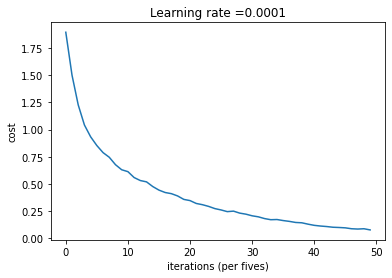

In [38]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

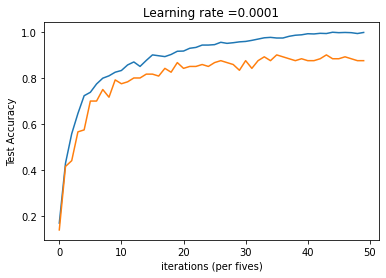

In [39]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

**Congratulations**! You've made it to the end of this assignment, and to the end of this week's material. Amazing work building a neural network in PyTorch!